# Rescale Images based on Projector Greyscale Transfer Function

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
import seaborn as sns; sns.set()

Specify measured screen brightness as a function of the stimulus no. from 1-11. 

In [2]:
Dir = "/Volumes/jayaramanlab/Shivam/" #connect to dm11
file = "brightness_level_6.csv"
df = pd.read_csv(Dir+file)

In [3]:
df['Stim'] = 12-df['Stim']

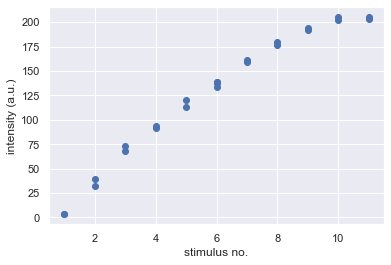

In [4]:
plt.plot(df['Stim'],df['I'],'o')
plt.xlabel("stimulus no.")
plt.ylabel("intensity (a.u.)")
plt.savefig(Dir+file[:-3],dpi=300)

In [5]:
mean_brightness = df.groupby(['Stim']).mean().round(2).reset_index()
mean_brightness['Stim'] = np.linspace(0,255,num=len(mean_brightness['Stim']))
mean_brightness['I'] = 255*(mean_brightness['I']-mean_brightness['I'].min())/(mean_brightness['I'].max()-mean_brightness['I'].min())

In [6]:
mean_brightness

,Stim,I
0,0.0,0.000000
1,25.5,40.757418
2,51.0,84.733860
3,76.5,113.375578
4,102.0,143.474728
5,127.5,169.353660
6,153.0,199.047264
7,178.5,221.605785
8,204.0,240.679141
9,229.5,253.859401


## Calculate Mean Brightness

In [7]:
mean_brightness.to_csv(Dir+"mean_"+file)

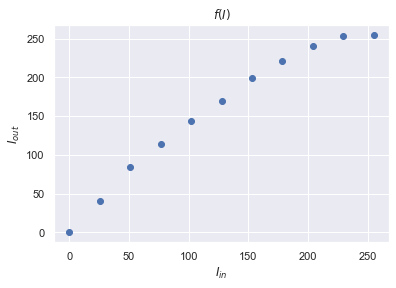

In [8]:
plt.figure()
b = sp.interpolate.interp1d(mean_brightness['Stim'], mean_brightness['I'],bounds_error=False)

plt.plot(mean_brightness['Stim'],mean_brightness['I'],'o');
plt.xlabel("$I_{in}$"); plt.ylabel("$I_{out}$");
plt.title(r'$f(I)$');

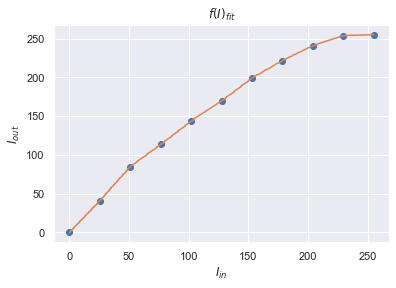

In [9]:
from scipy.optimize import minimize

y = np.array(mean_brightness['I'])
x = np.arange(0,256,1)
y = np.zeros(x.shape)

def diff(x,a):
    yt = b(x)
    return (yt - a)**2

for idx,x_value in enumerate(x):
    res = minimize(diff, 1.0, args=(x_value), method='Nelder-Mead', tol=1e-6)
    y[idx] = res.x[0]

plt.plot(mean_brightness['Stim'],mean_brightness['I'],'o');
plt.plot(np.round(y).astype('int'),x)
plt.title(r'$f(I)_{fit}$')
plt.ylabel("$I_{out}$"); plt.xlabel("$I_{in}$");
plt.savefig(Dir+"mean_"+file[:-3]+"_fit.png",dpi=300)

In [10]:
lookupDf = pd.DataFrame(np.array([np.round(y).astype('int'),x]).T, columns = ["Iin", "Iout"])

Save lookup table

In [11]:
lookupDf.to_csv(Dir+"lookup_table_transformed_brightness.csv")

In [12]:
def rescale(img):
    x = img.flatten()
    y = np.array(lookupDf.iloc[x]['Iin'])
    imgT = y.reshape(np.shape(img))
    return imgT

In [14]:
from PIL import Image
mg = np.asarray(Image.open('calibration/BrightnessSteps_Low.png'))

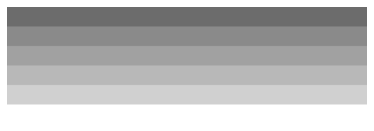

In [16]:
fig = plt.figure(frameon=False)
fig.set_size_inches(5,5)
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)
ax.imshow(rescale(mg), cmap='gray');
plt.savefig('calibration/BrightnessSteps_Low_reshaped.png',dpi = 300);

## Confirm Transformed Image is Linear on the Projector Screen

In [15]:
Dir = "/Volumes/jayaramanlab/Shivam/"
file = "brightness_level_6_transformed.csv"
dfT = pd.read_csv(Dir+file)

In [16]:
dfT['Stim'] = 12-dfT['Stim']

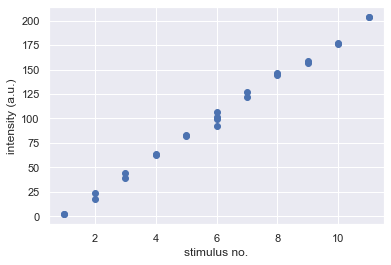

In [20]:
plt.plot(dfT['Stim'],dfT['I'],'o')
plt.xlabel("stimulus no.")
plt.ylabel("intensity (a.u.)")
plt.savefig(Dir+file[:-3],dpi=300)